In [211]:
import numpy as np 
import pandas as pd 

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [212]:
# Отключим некритичные предупреждения, расширим отображение датафреймов
warnings.filterwarnings("ignore")
pd.options.display.max_rows=100
pd.options.display.max_columns=50

In [213]:
# Фиксируем параметры среды
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [214]:
data_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
data_test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [215]:
print('Train size: ', data_train.shape)
print('Test size: ', data_test.shape)
print('SS size: ', sample_submission.shape)

Train size:  (73799, 19)
Test size:  (36349, 18)
SS size:  (24354, 2)


In [216]:
data_train.sample(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
2211,45316,21FEB2014,SCH,M,38,N,N,0,0,-2.178021,0,40,2,3,18000,4,1,N,1
43719,51176,27FEB2014,GRD,M,32,Y,Y,1,1,-1.301824,0,80,2,3,37000,1,4,Y,0
55292,5364,12JAN2014,SCH,M,37,N,N,1,1,-1.355392,0,70,1,2,30000,1,3,N,1
14773,34938,11FEB2014,GRD,M,33,Y,Y,0,0,-3.359350,2,60,2,3,50000,1,3,N,0
32605,23403,30JAN2014,UGR,F,25,N,N,0,0,-2.000101,1,50,2,3,18000,1,3,N,0
29927,104771,23APR2014,GRD,M,44,Y,Y,0,0,-2.216469,11,60,2,3,400000,1,4,N,0
7150,103560,22APR2014,GRD,M,28,Y,Y,0,0,-1.572293,2,50,1,2,35000,1,3,N,0
41381,59925,09MAR2014,PGR,F,33,Y,Y,0,0,-2.368712,5,50,1,1,80000,2,1,N,0
53371,86367,02APR2014,SCH,M,35,Y,Y,1,0,-1.947993,0,50,1,3,80000,1,1,N,1
29005,53147,02MAR2014,GRD,M,34,Y,Y,0,0,-2.264690,1,50,1,1,70000,1,3,N,0


- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту - Целевая переменная

# Functions

In [217]:
### Функция возвращает датафрейм с ключевыми метриками модели

def model_metrics (y_valid, y_pred, y_pred_prob):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']
    value = [
        accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred),
        recall_score(y_valid,y_pred), f1_score(y_valid,y_pred),
        roc_auc_score(y_valid, y_pred_prob)
    ]
    return(pd.DataFrame({'Метрика': metrics, 'Значение': value}))

In [218]:
### Функция отображает ROC-AUC кривую

def ROC_curve (y_valid, y_pred_prob):

    fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [219]:
### Функция отображает confusion matrix модели

def conf_matrix(model, X_valid, y_valid):
    sns.set_style('white')
    disp = plot_confusion_matrix(model, X_valid, y_valid, cmap='Blues')
    disp.ax_.set_title('confusion_matrix')
    print(disp.confusion_matrix)

In [220]:
### Функция для подбора внешних параметров модели логистической регрессии для достижения лучшего значения метрики 'f1-score'

def lr_hyper_optimize (X_train, y_train):
    
    model = LogisticRegression(random_state=RANDOM_SEED)

    C = np.logspace(-1, 4, 8)

    iter_max = 100

    param_grid = [
        {'C':C,
         'penalty': ['l1'], 
         'solver': ['liblinear', 'lbfgs'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_max]},
        {'C':C,
         'penalty': ['l2'], 
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_max]},
        {'C':C,
         'penalty': ['none'], 
         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_max]},
    ]

    gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
    gridsearch.fit(X_train, y_train)
    best_model = gridsearch.best_estimator_
    return(best_model)

In [221]:
### Функция для подбора внешних параметров модели логистической регрессии для достижения лучшего значения метрики 'roc-auc'

def lr_hyper_optimize_auc (X_train, y_train):
    
    model = LogisticRegression(random_state=RANDOM_SEED)

    C = np.logspace(-1, 4, 8)

    iter_max = 100

    param_grid = [
        {'C':C,
         'penalty': ['l1'], 
         'solver': ['liblinear', 'lbfgs'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_max]},
        {'C':C,
         'penalty': ['l2'], 
         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_max]},
        {'C':C,
         'penalty': ['none'], 
         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
         'class_weight':['none', 'balanced'], 
         'multi_class': ['auto','ovr'], 
         'max_iter':[iter_max]},
    ]

    gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1)
    gridsearch.fit(X_train, y_train)
    best_model = gridsearch.best_estimator_
    return(best_model)

In [222]:
### Функция для подбора внешних параметров модели RandomForestClassifier 

def rfc_hyper_optimize (X_train, y_train):
    rfc = RandomForestClassifier()
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    max_features = ['log2', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
    min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
    min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
    bootstrap = [True, False]
    class_weight=['balanced_subsample']
    param_dist = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap,
                   'class_weight': class_weight
                 }
    rs = RandomizedSearchCV(rfc, 
                            param_dist, 
                            n_iter = 100, 
                            scoring='f1',
                            cv = 3, 
                            verbose = 1, 
                            n_jobs=-1, 
                            random_state=RANDOM_SEED)
    rs.fit(X_train, y_train)
    best_model = rs.best_estimator_
    return(best_model)

In [223]:
### Функция для построения графика метрики при кросс-валидации

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [224]:
# Объединим данные для предобработки, предварительно отметив тестовую выборку

data_train['train'] = 1 
data_test['train'] = 0 

data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Пропуски наблюдаются только в 'education'. Ну и в целевой переменной на тестовой выборке.

In [226]:
data.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

In [227]:
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Заполним пропуски наиболее часто встречающимся значением. У всех как минимум имеется школьное образование.

In [228]:
data['education'].fillna(data['education'].mode()[0], inplace=True)

Заполним отсутствующие целевые переменные тестовой выборки нулями

In [229]:
data['default'].fillna(0, inplace=True)

In [230]:
# сгруппируем признаки по категориям

# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] 

# категорийные признаки
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# числовые признаки
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income'] 

In [231]:
# Преобразуем признак с датой заявки
data['app_date'] = pd.to_datetime(data.app_date)

In [232]:
data['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

Все заявки в датасете от 2014 года

<AxesSubplot:>

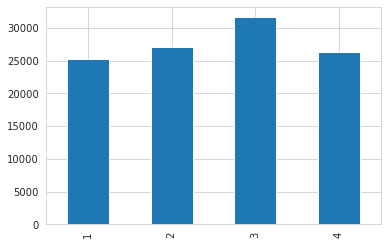

In [233]:
data['app_date'].dt.month.value_counts().plot.bar()

Заявки все в пределах 4-х месяцев

Создадим новый числовой признак - количество дней от даты заявки до 01.01.2014. До текущего дня слишком большое расстояние, а смысл тот же.

In [234]:
data['days_num'] = (data['app_date'] - pd.to_datetime('01/01/2014')).dt.days

In [235]:
# Создадим новый числовой признак - суммарное количество заявок поданных в дату заявки
applications = data.app_date.value_counts()
data['app_per_day'] = data.app_date.apply(lambda x: applications[x])

In [236]:
#Обновим список колонок с числовыми признаками
num_cols += ['days_num','app_per_day']

In [237]:
# Создадим новый категориальный признак - день недели заявки.
data['app_wkday'] = data['app_date'].dt.weekday.astype(int)

In [238]:
#Обновим список колонок с категориальными признаками
cat_cols.append('app_wkday')

# EDA

<AxesSubplot:xlabel='default', ylabel='count'>

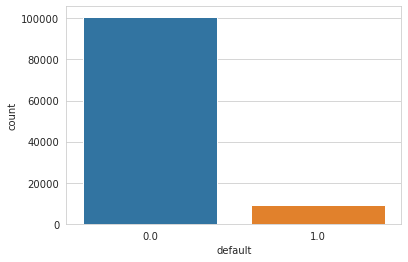

In [239]:
# А что у нас с целевой переменной?
sns.set_style('whitegrid')
sns.countplot(data['default'])

Видим несбалансированность классов целевой переменной в выборке. Над этим стоит подумать.

Посмотрим на распределение числовых переменных

In [240]:
num_cols

['age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'days_num',
 'app_per_day']

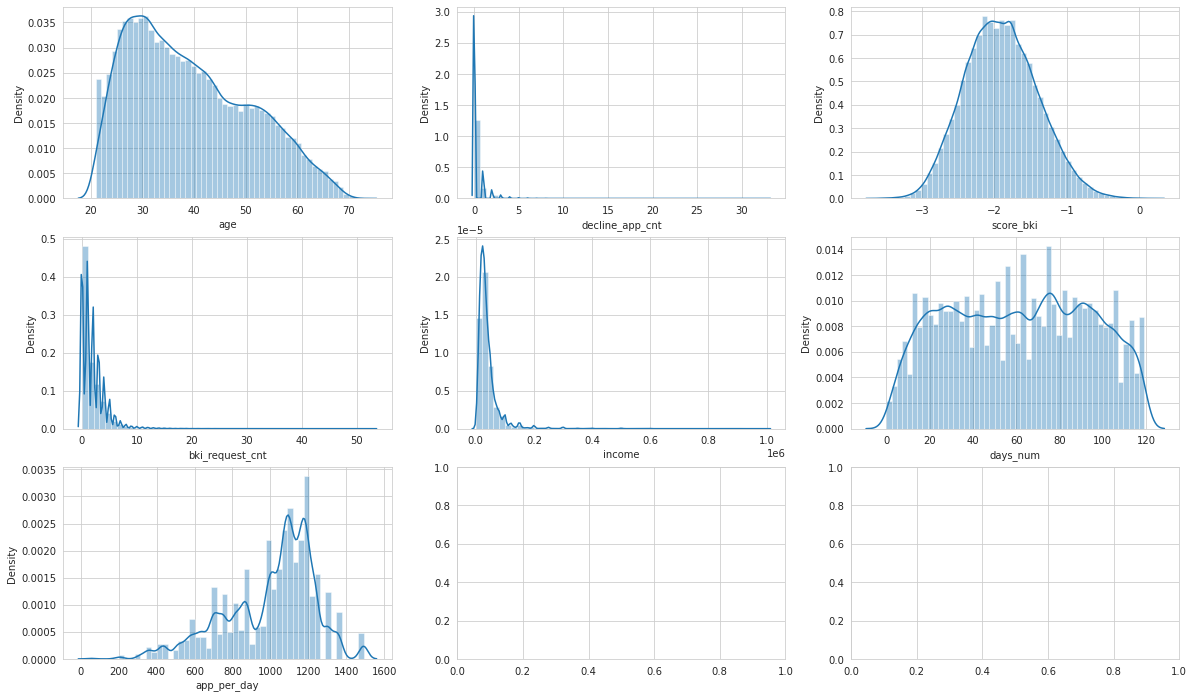

In [241]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(data[col], ax=axes.flat[i])

Нормально распределен только балл БКИ. Количество отказанных заявок, количество запросов и доход имеют большие правые хвосты

Прологарифмируем числовые признаки и посмотрим на получившееся распределение

In [242]:
cols_tolog = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'app_per_day']

for i in cols_tolog:
    data[i] = np.log(data[i] + 1)

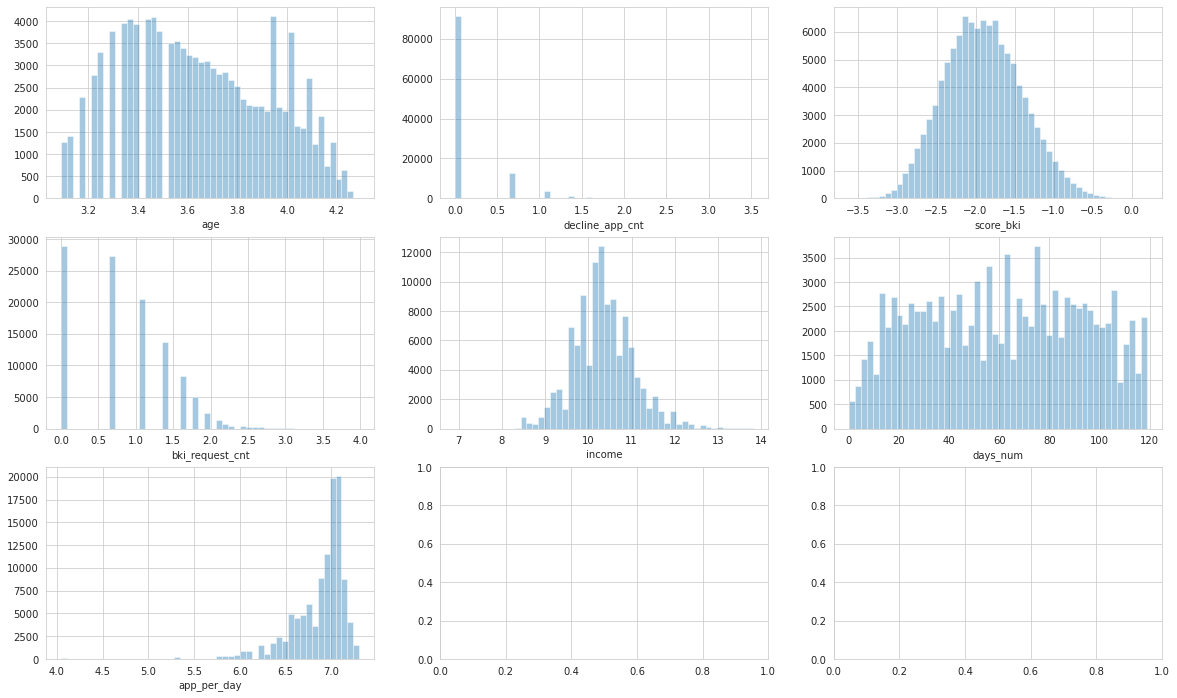

In [243]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(data[col], kde=False, ax=axes.flat[i])

Ситуация с хвостами несколько улучшилась. Нормализовалось распределение у income. Оставим числовые признаки в таком виде.

Посмотрим на выбросы числовых признаков и на особенности дефолтных клиентов

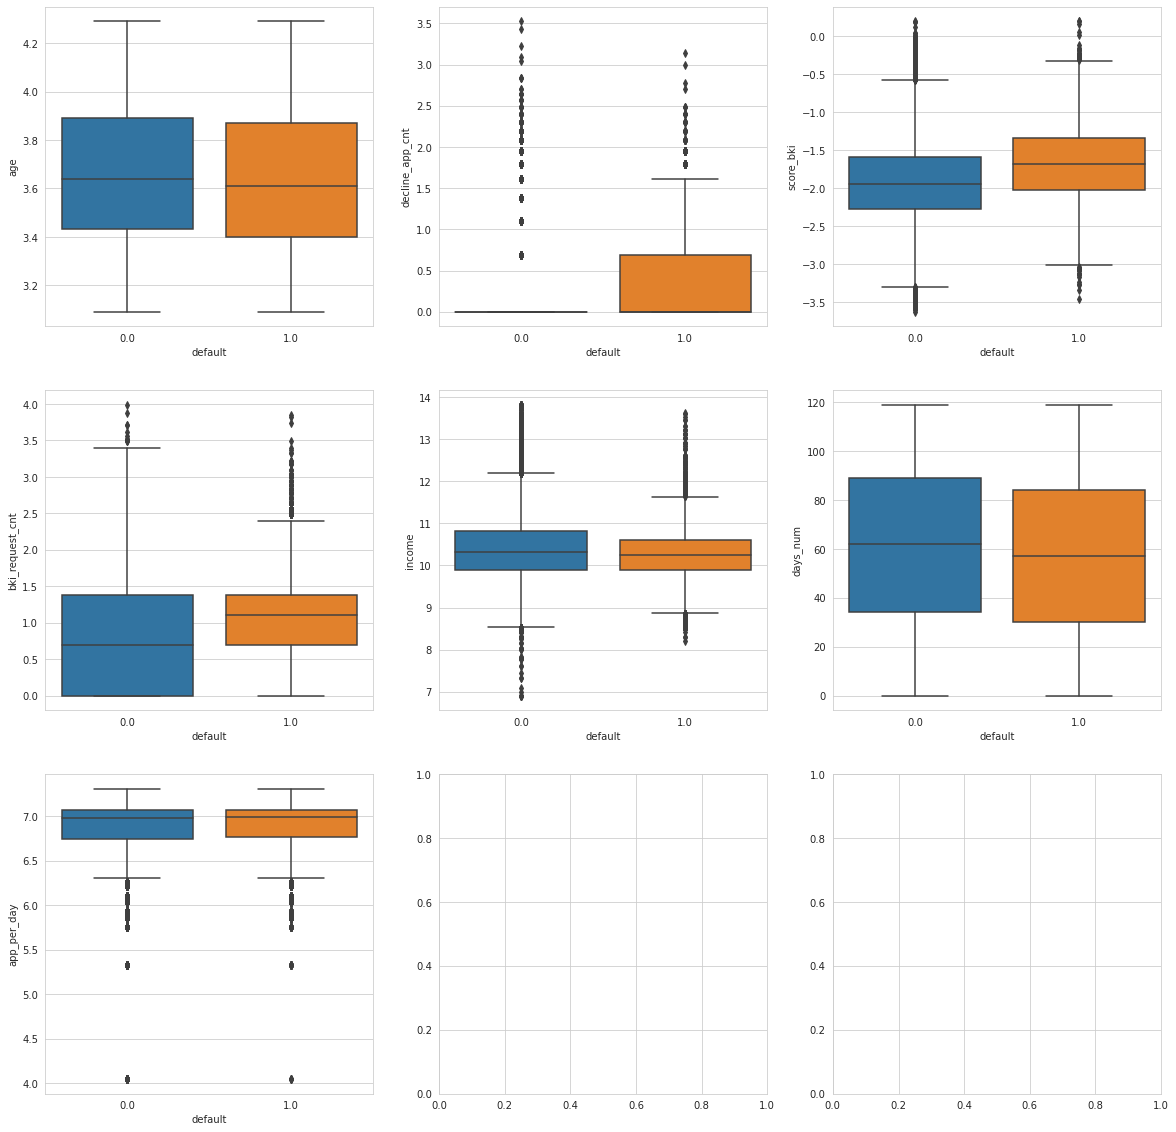

In [244]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, i in zip(num_cols, range(7)):
    sns.boxplot(x='default', y=col,
                data=data, showfliers=True, ax=axes.flat[i]);

Дефолтные клиенты моложе. Им чаще отказывают. Балл БКИ - чем ниже нуля, тем лучше. У дефолтных клиентов больше запросов в БКИ. У дефолтных клиентов более низкие доходы.

Все признаки, кроме возраста имеют выбросы.
Отбрасывать выбросы в данном случае - не лучшая идея, это скорее всего достоверные данные клиентов.
Для уменьшения влияния выбросов, мы будем нормировать числовые признаки при помощи RobustScaler.

Оценим значимость числовых признаков при помощи дисперсионного анализа ANOVA

<AxesSubplot:>

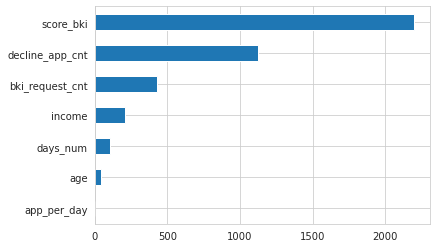

In [245]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind = 'barh')

Оценим корелляцию числовых признаков

<AxesSubplot:>

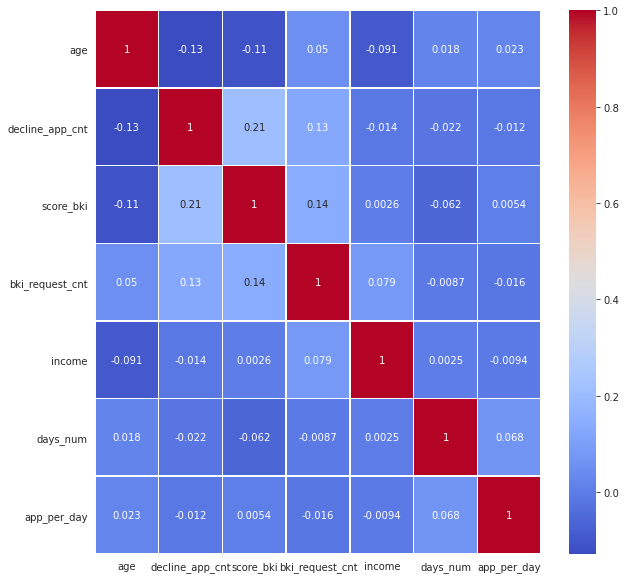

In [246]:
correlation = data[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

Значимая корелляция между числовыми признаками отсутствует. Используем все признаки

Посмотрим на содержание бинарных и категорийных признаков и распределение целевой переменной по ним.

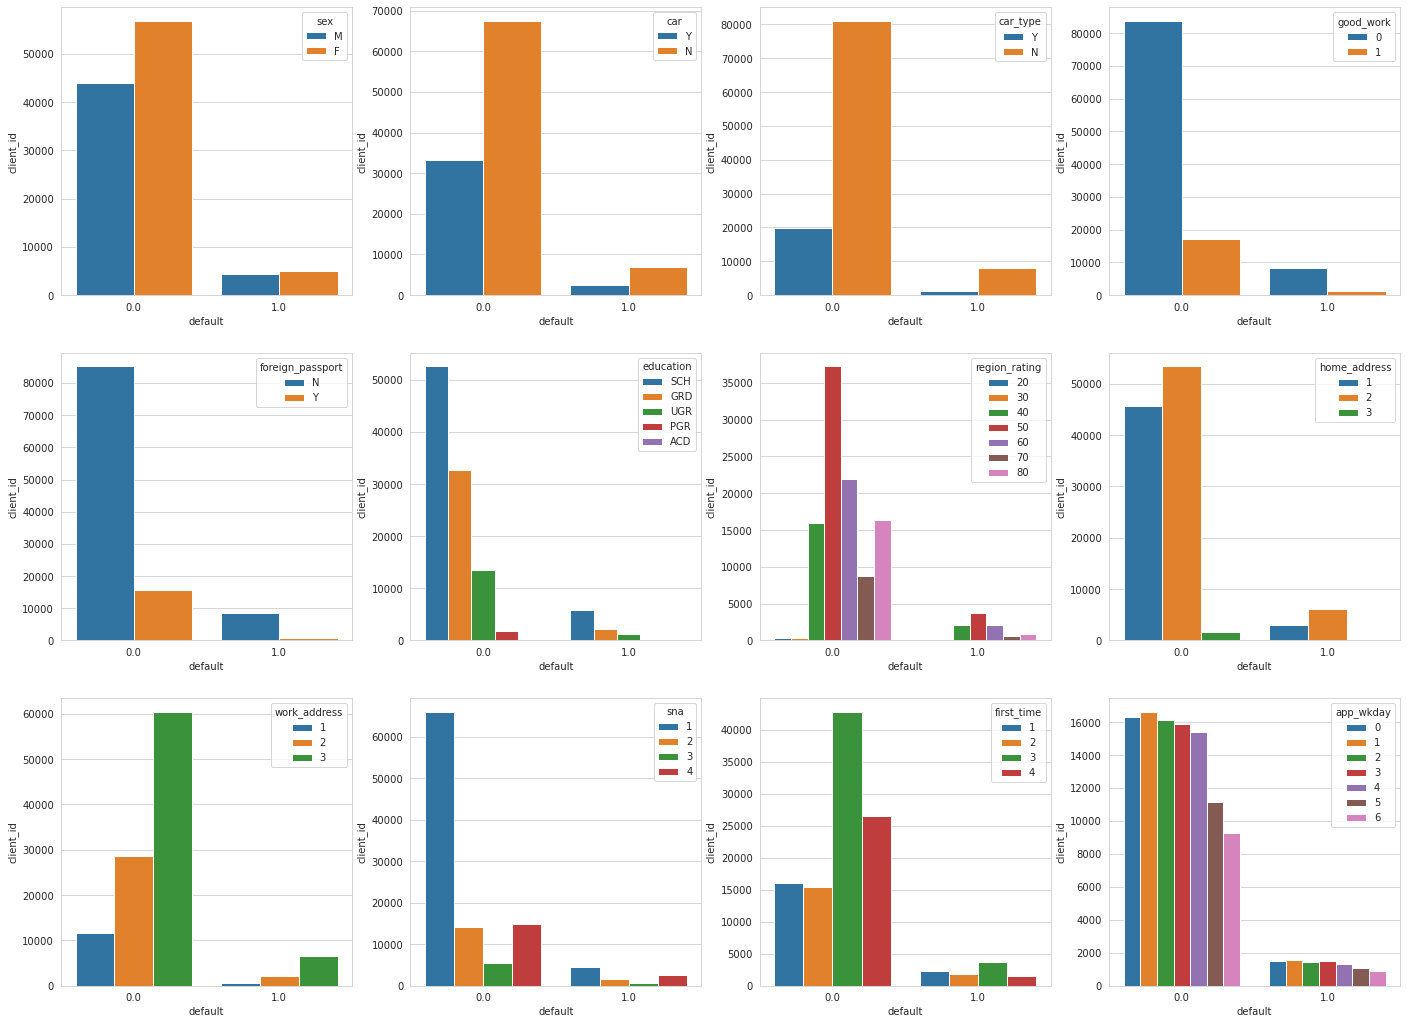

In [247]:
fig, axes = plt.subplots(3, 4, figsize=(24, 18))
for col, i in zip (bin_cols+cat_cols, range(12)):
    sns.barplot(x='default', y='client_id', hue=col, data=data, estimator=len, ax=axes.flat[i]);

Особенно значимых выводов сделать не получится. Распределения дефолтных и недефолтных заявок похожи. Наблюдения следующие: Среди дефолтных клиентов не видно высших степеней образования. Мало клиентов с низким рейтингом региона. 

Закодируем бинарные признаки при помощи LabelEncoder

In [248]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

Перекодируем признак образования, чем выше уровень образования - тем выше ранг переменной

In [249]:
conditions = [data.education == 'SCH',
              data.education == 'GRD',
              data.education == 'UGR',
              data.education == 'PGR',
              data.education == 'ACD']

choices = [1, 3, 2, 4, 5]

data['education'] = np.select(conditions, choices, default=np.nan)
data['education'] = data['education'].astype(int)

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif

Text(0.5, 0, 'F-value')

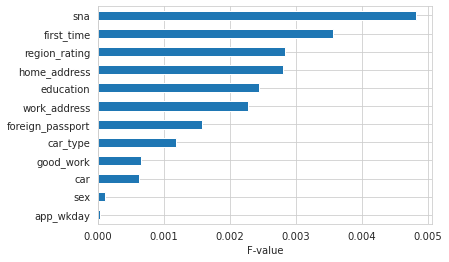

In [250]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind = 'barh')
plt.xlabel('F-value')

Создадим dummy-переменные из категориальных признаков

In [251]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

Отнормируем числовые признаки при помощи RobustScaler, который лучше обращается с выбросами

In [252]:
scaler = RobustScaler()

data[num_cols] = scaler.fit_transform(data[num_cols].values)

Добавим к датасету полиномиальные признаки, созданные из числовых переменных

In [253]:
pf = PolynomialFeatures(degree=2, interaction_only=False)
poly_features = pf.fit_transform(data[num_cols]) 
pf_df = pd.DataFrame(poly_features)
pf_df.columns = pf.get_feature_names()
pf_todrop = pf_df.columns[:len(num_cols)+1]
pf_df.drop(pf_todrop, axis=1, inplace = True)
data=data.join(pf_df)

Уберем колонку с датой заявки и колонку с идентификатором клиента, не несущую смысловую нагрузку

In [254]:
data.drop(['app_date', 'client_id'], axis=1, inplace=True)

# ML

Разделим обратно трейн и тест. И разобъем тест на признаки и целевую переменную

In [255]:
train_data = data[data['train'] == 1].drop(['train'], axis=1)
test_data = data[data['train'] == 0].drop(['train'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

Разобъем train выборку, чтобы сохранить пропорцию классов при разбиении? применим стратификацию 

In [256]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 74), (73799, 74), (73799, 73), (59039, 73), (14760, 73))

Возьмем модель логистической регрессии с базовыми настройками, обучим и посмотрим на метрики, кривую ROC-AUC и матрицу ошибок

In [257]:
model_base = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)

model_base.fit(X_train, y_train)

y_pred_proba = model_base.predict_proba(X_valid)[:,1]
y_pred = model_base.predict(X_valid)

In [258]:
model_base_m = model_metrics(y_valid, y_pred, y_pred_proba)
model_base_m

,Метрика,Значение
0,accuracy,0.872019
1,precision,0.441860
2,recall,0.030416
3,f1_score,0.056915
4,roc_auc_score,0.738087


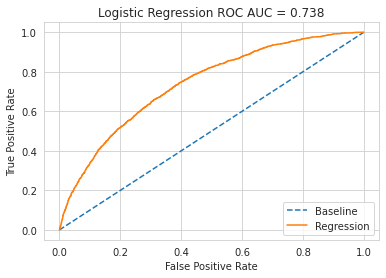

In [259]:
ROC_curve(y_valid, y_pred_proba)

[[12814    72]
 [ 1817    57]]


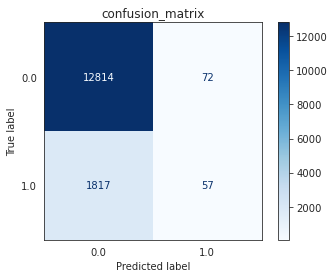

In [260]:
conf_matrix(model_base, X_valid, y_valid)

- f1_score = 0.057
- recall = 0.030

Очень низкая полнота модели. 
Из 1874 дефолтных клиентов модель верно определила лишь 57.
Значение метрики ROC-AUC 0.738 не должно нас обнадеживать.

Можно предположить, что это происходит из-за того, что определяемый класс в модели несбалансирован.

Попробуем подобрать параметры модели

In [261]:
# model_first = lr_hyper_optimize (X_train, y_train)
# model_first

In [262]:
# model_first_auc = lr_hyper_optimize_auc (X_train, y_train)
# model_first_auc

In [263]:
# Модель после оптимизации по F1-score
model_first = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   random_state=RANDOM_SEED, solver='liblinear')

In [264]:
# Модель после оптимизации по ROC-AUC score
model_first_auc = LogisticRegression(C=0.1, class_weight='none', random_state=RANDOM_SEED)

In [265]:
model_first_auc.fit(X_train, y_train)

y_pred_proba = model_first_auc.predict_proba(X_valid)[:,1]
y_pred = model_first_auc.predict(X_valid)

In [266]:
model_first_auc_m=model_metrics(y_valid, y_pred, y_pred_proba)
model_first_auc_m

,Метрика,Значение
0,accuracy,0.872087
1,precision,0.441667
2,recall,0.028282
3,f1_score,0.053159
4,roc_auc_score,0.737986


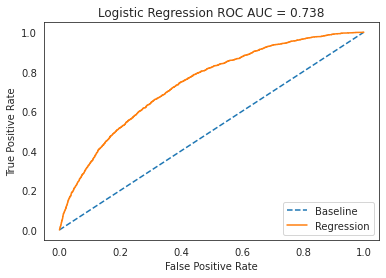

In [267]:
ROC_curve(y_valid, y_pred_proba)

[[12819    67]
 [ 1821    53]]


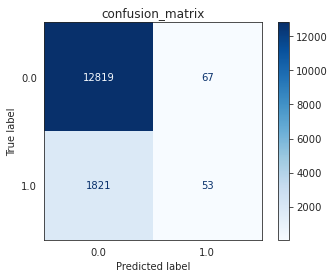

In [268]:
conf_matrix(model_first_auc, X_valid, y_valid)

Если подбирать параметры модели с целью улучшения ROC-AUC ничего хорошего не выходит. Но можно забраться повыше в таблице соревнования.

При подборе параметров для улучшения метрики F1-score уже получается что-то похожее на рабочую модель.

In [269]:
model_first.fit(X_train, y_train)

y_pred_proba = model_first.predict_proba(X_valid)[:,1]
y_pred = model_first.predict(X_valid)

In [270]:
model_first_m = model_metrics(y_valid, y_pred, y_pred_proba)
model_first_m

,Метрика,Значение
0,accuracy,0.668902
1,precision,0.228412
2,recall,0.676094
3,f1_score,0.341463
4,roc_auc_score,0.738051


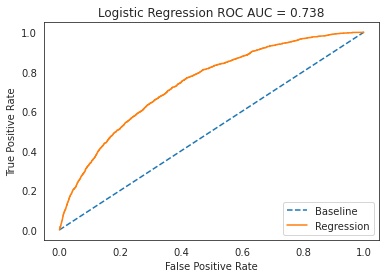

In [271]:
ROC_curve(y_valid, y_pred_proba)

[[8606 4280]
 [ 607 1267]]


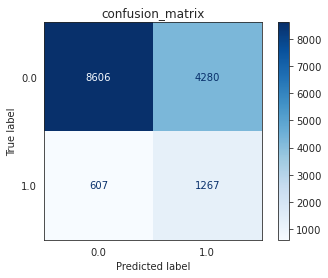

In [272]:
conf_matrix(model_first, X_valid, y_valid)

После подбора параметров модели метрики значительно улучшились. Оптимизатор предложил параметр class_weight='balanced', как раз отвечающий за балансировку классов. Модель стала значительно лучше предсказывать дефолт. Но в то же время стала предсказывать дефолт там, где его нет. Увеличилась доля False Positive предсказаний.

Попробуем две методики балансировки классов целевой переменной в выборке и обучим модель на результирующей сбалансированной выборке

# OVERSAMPLING

Обогатим обучающую часть train выборки при помощи модуля SMOTE (Synthetic Minority Over-sampling Technique)

In [273]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# импорт модуля SMOTE из библиотеки imblearn

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_SEED)

X_train_os, y_train_os = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_os.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_os == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_os == 0)))

Before OverSampling, counts of label '1': 7498
Before OverSampling, counts of label '0': 51541 

After OverSampling, the shape of train_X: (103082, 73)
After OverSampling, the shape of train_y: (103082,) 

After OverSampling, counts of label '1': 51541
After OverSampling, counts of label '0': 51541


In [274]:
# Подберем гиперпараметры для OS-выборки
# model_os = lr_hyper_optimize (X_train_os, y_train_os)
# model_os

In [275]:
model_os = LogisticRegression(C=0.5179474679231212, class_weight='balanced', random_state=RANDOM_SEED)

In [276]:
model_os.fit(X_train_os, y_train_os)

y_pred_os_proba = model_os.predict_proba(X_valid)[:,1]
y_pred_os = model_os.predict(X_valid)

In [277]:
model_os_m = model_metrics(y_valid, y_pred_os, y_pred_os_proba)
model_os_m

,Метрика,Значение
0,accuracy,0.670054
1,precision,0.226543
2,recall,0.662220
3,f1_score,0.337595
4,roc_auc_score,0.729459


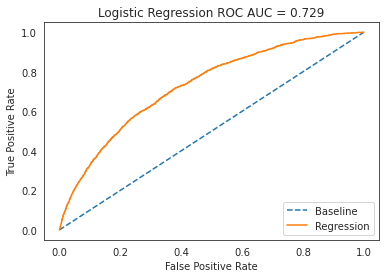

In [278]:
ROC_curve(y_valid, y_pred_os_proba)

[[8649 4237]
 [ 633 1241]]


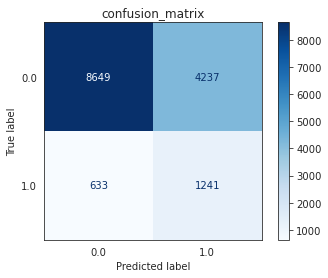

In [279]:
conf_matrix(model_os, X_valid, y_valid)

# UNDERSAMPLING

Уравновесим классы в обучающей части train выборки удалив записи с преобладающим классом при помощи RandomUnderSampler

In [280]:
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

  
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=RANDOM_SEED)

X_train_us, y_train_us = rus.fit_resample(X_train, y_train.ravel())

print('After UnderSampling, the shape of train_X: {}'.format(X_train_us.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_us.shape))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_us == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_us == 0)))

Before UnderSampling, counts of label '1': 7498
Before UnderSampling, counts of label '0': 51541 

After UnderSampling, the shape of train_X: (14996, 73)
After UnderSampling, the shape of train_y: (14996,) 

After UnderSampling, counts of label '1': 7498
After UnderSampling, counts of label '0': 7498


In [281]:
# Оптимизируем модель
# model_us = lr_hyper_optimize (X_train_us, y_train_us)
# model_us 

In [282]:
model_us = LogisticRegression(C=10000.0, class_weight='balanced', random_state=RANDOM_SEED, solver='liblinear')

In [283]:
model_us.fit(X_train_us, y_train_us)

y_pred_proba_us = model_us.predict_proba(X_valid)[:,1]
y_pred_us = model_us.predict(X_valid)

In [284]:
model_us_m = model_metrics(y_valid, y_pred_us, y_pred_proba_us)
model_us_m

,Метрика,Значение
0,accuracy,0.664905
1,precision,0.226398
2,recall,0.678228
3,f1_score,0.339476
4,roc_auc_score,0.736638


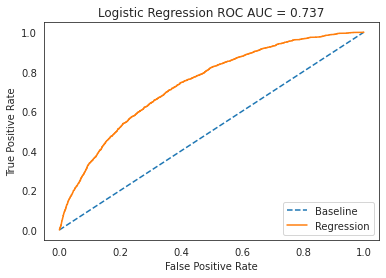

In [285]:
ROC_curve(y_valid, y_pred_proba_us)

[[8543 4343]
 [ 603 1271]]


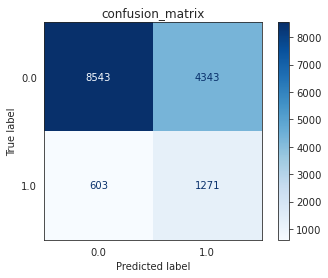

In [286]:
conf_matrix(model_us, X_valid, y_valid)

Oversampling дает результаты получше, чем Undersampling. Сравним характеристики трех опробованных моделей.

In [287]:
model_first_m

,Метрика,Значение
0,accuracy,0.668902
1,precision,0.228412
2,recall,0.676094
3,f1_score,0.341463
4,roc_auc_score,0.738051


In [288]:
model_os_m

,Метрика,Значение
0,accuracy,0.670054
1,precision,0.226543
2,recall,0.662220
3,f1_score,0.337595
4,roc_auc_score,0.729459


In [289]:
model_us_m

,Метрика,Значение
0,accuracy,0.664905
1,precision,0.226398
2,recall,0.678228
3,f1_score,0.339476
4,roc_auc_score,0.736638


Наилучшее значение метрик показала модель обученная на оптимизированных гиперпараметрах. Без искусственного балансирования классов.

Precision (Точность) - 22.8% заявок, которые модель определила как дефолтные, действительно являются дефолтными.

Recall (Полнота) - 67.6% заявок являющихся дефолтными, модель определила верно.

Модель получилась перестраховочной, и отказывает в выдаче избыточно много. 

ROC-AUC - 0.738

Попробуем решить задачу классификации при помощи классификатора "случайный лес"

In [290]:
rfc = RandomForestClassifier(random_state=RANDOM_SEED)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [291]:
y_pred_proba_rfc = rfc.predict_proba(X_valid)[:,1]
y_pred_rfc = rfc.predict(X_valid)

In [292]:
rfc_m = model_metrics(y_valid, y_pred_rfc, y_pred_proba_rfc)
rfc_m

,Метрика,Значение
0,accuracy,0.871680
1,precision,0.383721
2,recall,0.017609
3,f1_score,0.033673
4,roc_auc_score,0.698379


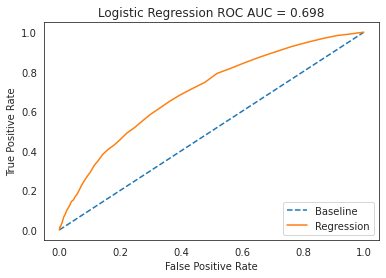

In [293]:
ROC_curve(y_valid, y_pred_proba_rfc)

[[12833    53]
 [ 1841    33]]


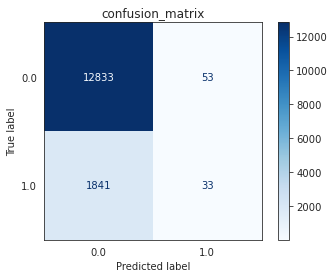

In [294]:
conf_matrix(rfc, X_valid, y_valid)

На базовых настройках модель получилась так себе. Попробуем оптимизировать параметры модели при помощи RandomizedSearchCV

In [295]:
#rfc_hyper_optimize (X_train, y_train)

In [296]:
# Подбор параметров дал такую модель, но ее метрики оказались ниже среднего
rfc2 = RandomForestClassifier(n_estimators=800, min_samples_split=12,
                              min_samples_leaf=7, max_features='sqrt',
                              max_depth=15, bootstrap=True, class_weight='balanced',
                              random_state=RANDOM_SEED)

In [297]:
# Попытка скорректировать параметры исходя из общих представлений о случайном лесе.
rfc3 = RandomForestClassifier(n_estimators=800, min_samples_split=2,
                              min_samples_leaf=2, max_features='sqrt',
                              max_depth=8, bootstrap=True, class_weight='balanced_subsample', oob_score=True,
                              random_state=RANDOM_SEED)

In [298]:
rfc3.fit(X_train, y_train)
y_pred_prob_rfc3 = rfc3.predict_proba(X_valid)[:,1]
y_pred_rfc3 = rfc3.predict(X_valid)

In [299]:
rfc3_m = model_metrics(y_valid, y_pred_rfc3, y_pred_prob_rfc3)
rfc3_m

,Метрика,Значение
0,accuracy,0.712602
1,precision,0.244938
2,recall,0.606724
3,f1_score,0.348987
4,roc_auc_score,0.728977


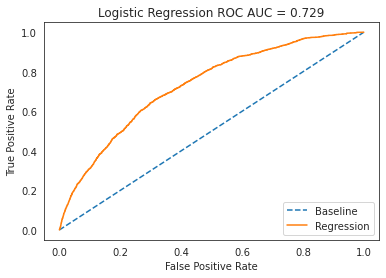

In [300]:
ROC_curve(y_valid, y_pred_prob_rfc3)

[[9381 3505]
 [ 737 1137]]


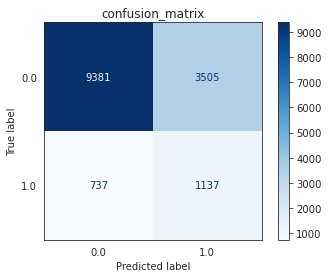

In [301]:
conf_matrix(rfc3, X_valid, y_valid)

Получилась неплохая модель которая немного хуже определяет дефолтных клиентов, ее F1-score наилучший из полученных, лучше точность, похуже полнота. 

Модель даже оказалась не сильно переобученной при проверке кросс валидацией. F1-score 0.38 (обучающая) vs 0.34 (валидационная)

Но ROC-AUC score не позволяет надеятся на хорошие результаты в лидерборде.

В сабмит отправляем модель model_first, оптимизированную логистическую регрессию на исходной выборке.

# Проверим модель на переобучение

Кросс-валидация

In [303]:
# На обучающей части разбиения
y_pred = model_first.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

[train] F1-score = 0.34


In [304]:
# На валидационной части разбиения
y_pred = model_first.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[valid] F1-score = 0.34


In [305]:
cv_metrics = cross_validate(model_first, X, y, cv=10, scoring='f1', return_train_score=True)

[train] F1-score = 0.34 +/- 0.00
[valid] F1-score = 0.34 +/- 0.01


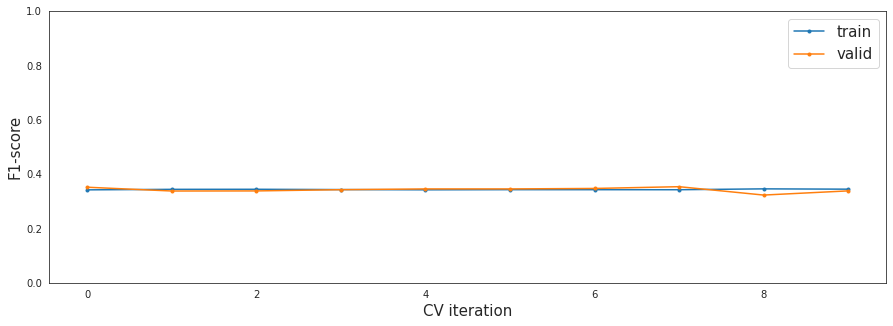

In [306]:
plot_cv_metrics(cv_metrics)

Переобучения не наблюдается.

# SUBMISSION

In [307]:
sample_submission.head(10)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
5,175,0.311599
6,57558,0.584807
7,88407,0.815792
8,79183,0.325037
9,69300,0.094011


In [308]:
X_test = test_data.drop(['default'], axis=1)

predict_submission = model_first.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default'] = predict_submission
submit.to_csv('submission.csv', index=False)

submit.head(10)

,client_id,default
0,74835,0.237544
1,17527,0.571760
2,75683,0.380307
3,26883,0.309713
4,28862,0.200130
5,99881,0.562996
6,26630,0.609032
7,79934,0.324420
8,16605,0.247867
9,105449,0.180043
